# Testing code for cost function "elasticity" on the annulus

In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the annulus and combuting the cocycle

(-2.194465123602417, 2.160667450671353, -2.0967295026542097, 2.18049931926066)

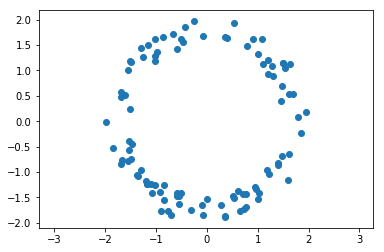

In [2]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = np.array([(rand_annulus_pt()) for x in range(100)])
plt.scatter(*annulus.T)
plt.axis('equal')

In [3]:
prime = 19
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

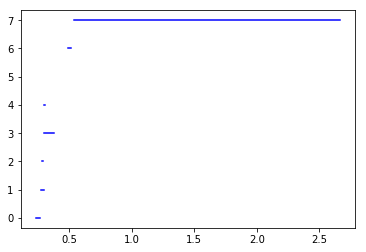

In [4]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [5]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.496083,2.74621)]

In [23]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 2.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.106833807207203,
 2.0919705626121297,
 -2.1534558929414667,
 2.162809928717171)

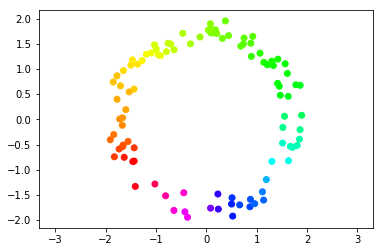

In [24]:
# subplot(121)#, projection="3d")
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

## Extract and optimize

In [ ]:
# Dionysus internal smoothing code:
def smooth(f, z, prime, show = False):
    """Smooth a given integer cocycle into a harmonic cocycle."""

    try:
        from scipy.sparse.linalg import lsqr
        from scipy.sparse        import csc_matrix
        import numpy as np
    except ImportError:
        raise ImportError("Unable to import lsqr from scipy.sparse.linalg. Have you installed scipy?")

    # Cocycle can be larger than D; we implicitly project it down

    data = []
    row  = []
    col  = []
    for i,s in enumerate(f):
        if s.dimension() == 1:
            for isb,sb in enumerate(s.boundary()):
                data.append(1. if isb % 2 == 0 else -1.)
                row.append(i)
                col.append(f.index(sb))

    row_max = max(row)           # x.index <= row_max condition below projects the cocycle to the filtration
    z_data = [x.element if x.element < prime/2 else x.element - prime for x in z if x.index <= row_max]
    z_row  = [x.index for x in z if x.index <= row_max]
    z_col  = [0 for x in z if x.index <= row_max]

    dim = max(row_max,max(col)) + 1
    D = csc_matrix((np.array(data), (np.array(row), np.array(col))), shape=(dim, dim))
    z = csc_matrix((z_data, (z_row, z_col)), shape=(dim, 1)).toarray()

    tol = 1e-10
    solution = lsqr(D, z, atol = tol, btol = tol, show = show)

    max_vrt = max(s[0] for s in f if s.dimension() == 0)

    vertex_values = [0. for _ in range(max_vrt + 1)]
    for i,x in enumerate(solution[0]):
        if f[i].dimension() == 0:
            vertex_values[f[i][0]] = x

    return vertex_values

In [20]:
import scipy.sparse
def extract(filtration, z, prime):
    data, row, col = [], [], [] # prepare for creating a sparse matrix
    for i,s in enumerate(filtration): # for each simplex in the filtration...
        if s.dimension() == 1: # only consider dim 1 simplices
            for isb, sb in enumerate(s.boundary()):
                data.append(pow(-1., isb))
                row.append(i) # do the boundary matrix transposition by hand
                col.append(filtration.index(sb))
                
    row_max = max(row)
    z_data = [mod(x.element, prime) - prime//2 for x in z if x.index <= row_max]
    z_row = [x.index for x in z if x.index <= row_max]
    z_col = [0 for x in z if x.index <= row_max]
    
    dim = max(row_max, max(col)) + 1 # total dimension of projected space
    D = scipy.sparse.csc_matrix((array(data), (array(row), array(col))), shape=(dim,dim))
    z = scipy.sparse.csc_matrix((z_data, (z_row, z_col)), shape=(dim,1))
    
    return {"bdry": D, "cocycle": z}

In [27]:
thr = 2.

bars = [bar for bar in dgms[1] if bar.death > thr and bar.birth < thr]
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_thr = dionysus.Filtration([s for s in vr if s.data <= thr])

bdry_cocycle = extract(vr_thr, cocycles[0], prime)
print(bdry_cocycle)
#f.T + bdry @ z.squeeze()
bdry = bdry_cocycle["bdry"].todense()
cocycle = bdry_cocycle["cocycle"].todense()

norm(cocycle + bdry @ eye(bdry.shape[0])[0])

{'bdry': <21202x21202 sparse matrix of type '<class 'numpy.float64'>'
	with 3874 stored elements in Compressed Sparse Column format>, 'cocycle': <21202x1 sparse matrix of type '<class 'numpy.int64'>'
	with 139 stored elements in Compressed Sparse Column format>}


14721.229704070241

In [12]:
D = {}
data = {}
indexing = {}
ix = [0]*50
thr = 2.

bars = [bar for bar in dgms[1] if bar.death > thr and bar.birth < thr]
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_thr = dionysus.Filtration([s for s in vr if s.data <= thr])

for s in vr_thr:
    if s.dimension() == 0:
        continue
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[s.dimension()-1][k] = ix[s.dimension()-1]
            ix[s.dimension()-1] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[s.dimension()-1][k]) #cols
        if dat%2:
            data[s.dimension()].append(-1)
        else:
            data[s.dimension()].append(1)
from scipy import sparse
CBd = [sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [15]:
[c2 for c2 in cocycles[0]]

[1*1770,
 1*2061,
 18*2399,
 1*2707,
 18*2929,
 1*3033,
 1*3732,
 18*3763,
 18*4151,
 1*4461,
 18*4467,
 1*4470,
 1*4488,
 18*4620,
 1*5083,
 18*5263,
 18*5397,
 18*5421,
 1*5650,
 18*5785,
 18*5833,
 1*6093,
 1*6132,
 18*6203,
 18*6337,
 18*6736,
 1*6979,
 1*7258,
 18*7306,
 1*7804,
 18*7885,
 1*8011,
 1*8031,
 18*8181,
 18*8363,
 1*8418,
 18*8500,
 18*8923,
 18*9278,
 18*9302,
 1*9543,
 1*9578,
 18*9609,
 18*9780,
 18*10055,
 1*10392,
 18*10666,
 18*10900,
 1*11281,
 1*11298,
 18*11453,
 1*11492,
 18*11610,
 18*11788,
 18*11930,
 18*11981,
 1*12140,
 18*12452,
 18*12556,
 1*12880,
 1*12933,
 18*13021,
 1*13167,
 18*13270,
 1*13303,
 18*13371,
 18*13384,
 18*13465,
 1*13627,
 18*13694,
 18*14108,
 1*14161,
 18*14284,
 1*14341,
 18*14417,
 1*14641,
 1*14794,
 18*15150,
 1*15176,
 18*15378,
 1*15456,
 18*15479,
 1*15490,
 18*15645,
 1*15772,
 18*15813,
 1*15850,
 18*15921,
 18*16047,
 1*16070,
 1*16117,
 18*16158,
 18*16442,
 1*16479,
 1*16577,
 18*16627,
 1*16823,
 1*16896,
 18*17031,


In [13]:
n, m = CBd[0].shape
l = array([1])

f = np.zeros((n,1))
for c2 in cocycles[0]:
    f[indexing[1][vr_thr[c2.index]]] = c2.element
bdry = CBd[0]

Automatic pdb calling has been turned ON


KeyError: <0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,19,19,19,20,20,20,20,20,20,20,20,20,21,21,21,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,23,23,23,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,25,25,25,25,25,25,25,25,25,25,26,26,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,28,28,28,28,29,29,29,29,29,29,29,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,32,32,32,32,32,32,32,32,32,32,32,33,33,33,34,34,34,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,36,36,36,36,37,37,37,37,37,37,37,37,38,38,38,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,40,40,40,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,43,43,43,43,43,43,43,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,49,49,49,49,49,49,49,49,49,49,50,50,50,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,52,52,52,52,52,52,52,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,54,54,54,54,54,55,55,55,55,55,55,55,55,55,55,56,56,56,57,57,57,57,57,57,57,58,58,58,58,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,65,65,65,65,65,65,65,65,65,65,66,66,66,66,66,66,66,66,66,66,66,67,67,67,67,68,68,68,68,68,68,68,68,68,68,68,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,73,73,73,73,73,73,73,73,73,73,73,73,73,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,76,76,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,78,78,79,79,79,79,79,79,79,79,79,79,79,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,81,81,81,81,81,81,81,81,81,81,82,82,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,84,84,84,84,85,85,85,85,86,86,86,86,86,86,86,87,87,87,87,87,87,87,87,87,87,87,87,87,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,93,93,93,93,93,93,93,93,93,93,93,93,94,94,94,94,94,94,94,94,94,94,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,97,97,97,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,99,99,99,99,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,32700,384094112,384094120,384094128,384094136,384094144,384094152,384094160,384094168,384094176,384094184,384094192,384094200,384094208,384094216,384094224,384094232,384094240,384094248,384094256,384094264,384094272,384094280,384094288,384094296,384094304,384094312,384094320,384094328,384094336,384094344,384094352,384094360,384094368,384094376,384094384,384094392,384094400,384094408,384094416,384094424,384094432,384094440,384094448,384094456,384094464,384094472,384094480,384094488,384094496,384094504,384094512,384094520,384094528,384094536,384094544,384094552,384094560,384094568,384094576,384094584,384094592,384094600,384094608,384094616,384094624,384094632,384094640,384094648,384094656,384094664,384094672,384094680,384094688,384094696,384094704,384094712,384094720,384094728,384094736,384094744,384094752,384094760,384094768,384094776,384094784,384094792,384094800,384094808,384094816,384094824,384094832,384094840,384094848,384094856,384094864,384094872,384094880,384094888,384094896,384094904,384094912,384094920,384094928,384094936,384094944,384094952,384094960,384094968,384094976,384094984,384094992,384095000,384095008,384095016,384095024,384095032,384095040,384095048,384095056,384095064,384095072,384095080,384095088,384095096,384095104,384095112,384095120,384095128,384095136,384095144,384095152,384095160,384095168,384095176,384095184,384095192,384095200,384095208,384095216,384095224,384095232,384095240,384095248,384095256,384095264,384095272,384095280,384095288,384095296,384095304,384095312,384095320,384095328,384095336,384095344,384095352,384095360,384095368,384095376,384095384,384095392,384095400,384095408,384095416,384095424,384095432,384095440,384095448,384095456,384095464,384095472,384095480,384095488,384095496,384095504,384095512,384095520,384095528,384095536,384095544,384095552,384095560,384095568,384095576,384095584,384095592,384095600,384095608,384095616,384095624,384095632,384095640,384095648,384095656,384095664,384095672,384095680,384095688,384095696,384095704,384095712,384095720,384095728,384095736,384095744,384095752,384095760,384095768,384095776,384095784,384095792,384095800,384095808,384095816,384095824,384095832,384095840,384095848,384095856,384095864,384095872,384095880,384095888,384095896,384095904,384095912,384095920,384095928,384095936,384095944,384095952,384095960,384095968,384095976,384095984,384095992,384096000,384096008,384096016,384096024,384096032,384096040,384096048,384096056,384096064,384096072,384096080,384096088,384096096,384096104,384096112,384096120,384096128,384096136,384096144,384096152,384096160,384096168,384096176,384096184,384096192,384096200,384096208,384096216,384096224,384096232,384096240,384096248,384096256,384096264,384096272,384096280,384096288,384096296,384096304,384096312,384096320,384096328,384096336,384096344,384096352,384096360,384096368,384096376,384096384,384096392,384096400,384096408,384096416,384096424,384096432,384096440,384096448,384096456,384096464,384096472,384096480,384096488,384096496,384096504,384096512,384096520,384096528,384096536,384096544,384096552,384096560,384096568,384096576,384096584,384096592,384096600,384096608,384096616,384096624,384096632,384096640,384096648,384096656,384096664,384096672,384096680,384096688,384096696,384096704,384096712,384096720,384096728,384096736,384096744,384096752,384096760,384096768,384096776,384096784,384096792,384096800,384096808,384096816,384096824,384096832,384096840,384096848,384096856,384096864,384096872,384096880,384096888,384096896,384096904,384096912,384096920,384096928,384096936,384096944,384096952,384096960,384096968,384096976,384096984,384096992,384097000,384097008,384097016,384097024,384097032,384097040,384097048,384097056,384097064,384097072,384097080,384097088,384097096,384097104,384097112,384097120,384097128,384097136,384097144,384097152,384097160,384097168,384097176,384097184,384097192,384097200,384097208,384097216,384097224,384097232,384097240,384097248,384097256,384097264,384097272,384097280,384097288,384097296,384097304,384097312,384097320,384097328,384097336,384097344,384097352,384097360,384097368,384097376,384097384,384097392,384097400,384097408,384097416,384097424,384097432,384097440,384097448,384097456,384097464,384097472,384097480,384097488,384097496,384097504,384097512,384097520,384097528,384097536,384097544,384097552,384097560,384097568,384097576,384097584,384097592,384097600,384097608,384097616,384097624,384097632,384097640,384097648,384097656,384097664,384097672,384097680,384097688,384097696,384097704,384097712,384097720,384097728,384097736,384097744,384097752,384097760,384097768,384097776,384097784,384097792,384097800,384097808,384097816,384097824,384097832,384097840,384097848,384097856,384097864,384097872,384097880,384097888,384097896,384097904,384097912,384097920,384097928,384097936,384097944,384097952,384097960,384097968,384097976,384097984,384097992,384098000,384098008,384098016,384098024,384098032,384098040,384098048,384098056,384098064,384098072,384098080,384098088,384098096,384098104,384098112,384098120,384098128,384098136,384098144,384098152,384098160,384098168,384098176,384098184,384098192,384098200,384098208,384098216,384098224,384098232,384098240,384098248,384098256,384098264,384098272,384098280,384098288,384098296,384098304,384098312,384098320,384098328,384098336,384098344,384098352,384098360,384098368,384098376,384098384,384098392,384098400,384098408,384098416,384098424,384098432,384098440,384098448,384098456,384098464,384098472,384098480,384098488,384098496,384098504,384098512,384098520,384098528,384098536,384098544,384098552,384098560,384098568,384098576,384098584,384098592,384098600,384098608,384098616,384098624,384098632,384098640,384098648,384098656,384098664,384098672,384098680,384098688,384098696,384098704,384098712,384098720,384098728,384098736,384098744,384098752,384098760,384098768,384098776,384098784,384098792,384098800,384098808,384098816,384098824,384098832,384098840,384098848,384098856,384098864,384098872,384098880,384098888,384098896,384098904,384098912,384098920,384098928,384098936,384098944,384098952,384098960,384098968,384098976,384098984,384098992,384099000,384099008,384099016,384099024,384099032,384099040,384099048,384099056,384099064,384099072,384099080,384099088,384099096,384099104,384099112,384099120,384099128,384099136,384099144,384099152,384099160,384099168,384099176,407396352,407396624,407398504,407398928,407399368,407400472,407400808,407401344,407401928,407402408,407403952,407404128,407404248,407404384,407404624,407405736,407406584,407407296,407407560,407409608,407410136,407410240,407410584,407411144,407411272,407411304,407411784,407412128,407412344,407412400,407412712,407412880,407412920,407413080,407413240,407413272,407413472,407414104,407415392,407415480,407415880,407415984,407416000,407416432,407416488,407416528,407416784,407418104,407418176,407419072,407419448,407419544,407419696,407419760,407419768,407419872,407419912,407420032,407420048,407420128,407421824,407422432,407422888,407423456,407423616,407425368,407426456,407426592,407426648,407426688,407427072,407427144,407427152,407427160,407427176,407427464,407427960,407428240,407428672,407428696,407429112,407429232,407429376,407430280,407430544,407430592,407430704,407430736,407430848,407430984,407431256,407431264,407431352,407431480,407433176,407433992,407434280,407435712,407435824,407436104,407436160,407436208,407437160,407437888,407438584,407439688,407441568,407442624,407443240,407443448,407444760,407445136,407445320,407445344,407445392,407446488,407446880,407447528,407448136,407448336,407448472,407448488,407449400,407449736,407449912,407450224,407450232,407450264,407450360,407450440,407450592,407451088,407451296,407451952,407452056,407452536,407452944,407453352,407453480,407455040,407455136,407455256,407455512,407456920,407457128,407457208,407457248,407457264,407457888,407458200,407458760,407458864,407458944,407459168,407459264,407459360,407461360,407461840,407461904,407461960,407461976,407462064,407462448,407462888,407463104,407463440,407465256,407465656,407466056,407466728,407467072,407467136,407467200,407470648,407473072,407473192,407474968,407475232,407475520,407475816,407476176,407476872,407476936,407477880,407477976,407478600,407479712,407480240,407480968,407481040,407481160,407481784,407483352,407483736,407485504,407485912,407486104,407486360,407486408,407486544,407486552,407486560,407486680,407486856,407486864,407487096,407487120,407487128,407487240,407487272,407487632,407488072,407488320,407488560,407488688,407488744,407488832,407489456,407489928,407491112,407491448,407491464,407491808,407491848,407492080,407492584,407492864,407493304,407493424,407493960,407494384,407494872,407494976,407495064,407495104,407495120,407495128,407495192,407495224,407495232,407495256,407495272,407496032,407496080,407496504,407497216,407497240,407497552,407497928,407498640,407499848,407500048,407500176,407500592,407500784,407500848,407501264,407501488,407501496,407501512,407502488,407502600,407502816,407503520,407503696,407503728,407503736,407503864,407503992,407504072,407504112,407504128,407504152,407504336,407505064,407505536,407505816,407505888,407506088,407506232,407506296,407506416,407506776,407506832,407507240,407507248,407507256,407507544,407507600,407507696,407507824,407507848,407508592,407508840,407509016,407509208,407509224,407509496,407509544,407509552,407509632,407509712,407509896,407510072,407510080,407510088,407510256,407511896,407511936,407512600,407512752,407512888,407513320,407513696,407513832,407513904,407514728,407515824,407515888,407516152,407516208,407516248,407516312,407516528,407516904,407516960,407517416,407517712,407517728,407518408,407518424,407518576,407518632,407518800,407518864,407518920,407519008,407519160,407519176,407519328,407520152,407520192,407520904,407521120,407521256,407521560,407521600,407521720,407521952,407522888,407523104,407523280,407523928,407524280,407524776,407524824,407525208,407525264,407525280,407525336,407526208,407526328,407526680,407527120,407527192,407527232,407527424,407528016,407528712,407530184,407530920,407531312,407531344,407531720,407531744,407531784,407531888,407532216,407532632,407532912,407533264,407533328,407535200,407535616,407536872,407537712,407537920,407537968,407538336,407538360,407538376,407538416,407538624,407538752,407539160,407539296,407539472,407539856,407539904,407540160,407540896,407540928,407541976,407542176,407542856,407543104,407543960,407544000,407544632,407545056,407545336,407545352,407545664,407545840,407546304,407546384,407546400,407546640,407546704,407546760,407546864,407547008,407547224,407548256,407548960,407549776,407550240,407550344,407551256,407552632,407553176,407553184,407553568,407553992,407554632,407554672,407555344,407555576,407556016,407556072,407558464,407558960,407560000,407560120,407560256,407560896,407561368,407561632,407561744,407562056,407562272,407562472,407563040,407563056,407563456,407564320,407564384,407564448,407564584,407564960,407565016,407565056,407565112,407565424,407566048,407566088,407566120,407566616,407566656,407567400,407567432,407567624,407568416,407568808,407569352,407569512,407569696,407570168,407570184,407570672,407572224,407573920,407574968,407575752,407575840,407576256,407576784,407576808,407576952,407576976,407577008,407577352,407577584,407577656,407577736,407578200,407578496,407578544,407578608,407578784,407578928,407579912,407580152,407580464,407580896,407580928,407581168,407581328,407581352,407581416,407581432,407581712,407581896,407581984,407582680,407582816,407584400,407584640,407585088,407585736,407586616,407586672,407587264,407587296,407587480,407587496,407587600,407587640,407587656,407587824,407587832,407587992,407588280,407588384,407588584,407588744,407589296,407589344,407589632,407590312,407592232,1010486800,1010489488,1010491216,1010492496,1010494608,1010497168,1010505936,1010513168,1010519376,1010521936,1010522640,1010524304,1011828032,1011828032,1011828288,1011831872,1011832384,1011834816,1011834944,1011841024,1011841856,1011842112,1011843328,1011843648,1011844032,1011844224,1011846080,1011846336,1011847552,1011848960,1011849664,1011849856,1011850112,1011850240,1011850880,1011851712,1011853568,1011853632,1011853760,1011854464,1011854528,1011855168,1011855488,1011856192,1011857664,1011960592,1011961168,1011962064,1011967264,1011970336,1011972832,1011973280,1011974752,1011975392,1011979680,1011980192,1011981536,1011982176,1011985376,1011985824,1011987808,1011990240,1011993056,1011994016,1011996256,1011996896,1011999264,1012000608,1012000672,1012001056,1012002336,1012004000,1012010144,1012013664,1012013792,1012018144,1012020128,1012023968,1012026208,1012026784,1012029152,1012030048,1012031520,1012032992,1012033440,1012035808,1012037920,1012039584,1012040352,1012042400,1012044384,1012045024,1012046432,1012048096,1012049760,1012050016,1012050912,1012053536,1012054496,1012055456,1012056288,1012058912,1012059360,1012060576,1012061984,1012063008,1012064992,1012065376,1012070112,1012070752,1012070880,1012070944,1012073376,1012075232,1012078240,1012085280,1012087520,1012087840,1012088928,1012090208,1012090336,1012091424,1012094688,1012097248,1012098464,1012102176,1012104224,1012104928,1012105824,1012106976,1012107232,1012109920,1012111328,1012112032,1012112544,1012116064,1012119776,1012121632,1012123232,1012124128,1012125984,1012126752,1012127584,1012132640,1012132704,1012135392,1012135392,1012135904,1012138592,1012141664,1012143072,1012145824,1012151904,1012152864,1012155616,1012156256,1012160160,1012160288,1012160352,1012160608,1012162912,1012170016,1012170976,1012171104,1012171744,1012173536,1012175904,1012178592,1012179872,1012183136,1012183776,1012184416,1012186464,1012186656,1012190368,1012191328,1012194784,1012195296,1012196384,1012199072,1012203168,1012210912,1012216544,1012218016,1012219040,1012219744,1012219808,1012221088,1012227296,1012233888,1012234400,1012234656,1012237024,1012240672,1012240992,1012241504,1012244192,1012244960,1012247264,1012247584,1012251680,1012253216,1012254176,1012254368,1012257888,1012258208,1012260768,1012261152,1012261472,1012261856,1012263328,1012264224,1012266208,1012267296,1012267872,1012268320,1012277088,1012277216,1012277280,1012279136,1012280288,1012280608,1012282016,1012285792,1012286112,1012289184,1012291360,1012295264,1012296736,1012310304,1012316384,1012316640,1012322144,1012324448,1012335072,1012335456,1012340576,1012342240,1012350112,1012350304,1012351776,1012354912,1012365856,1012373856,1012390176,1012391264,1012395936,1012396896,1012400864,1012406944,1012407968,1012414368,1012417696,1012419040,1012423904,1012424416,1012428640,1012429152,1012431200,1012439648,1012441824,1012445664,1012446240,1012457952,1012460320,1012470432,1012470752,1012476000,1012483488,1012491744,1012494624,1012500512,1012501280,1014061984,1014062176,1014062304,1014068256,1014069344,1014073184,1014073440,1014073568,1014075808,1014080288,1014080416,1014081120,1014082144,1014082336,1014084448,1014084464,1014084528,1014084592,1014084656,1014084720,1014084784,1014084832,1014084848,1014084896,1014084912,1014084976,1014085024,1014085040,1014085088,1014085104,1014085168,1014085232,1014085296,1014085344,1014085360,1014085408,1014085424,1014085472,1014085488,1014085552,1014085616,1014085680,1014085728,1014085744,1014085808,1014085872,1014085936,1014086000,1014086064,1014086128,1014086192,1014086240,1014086256,1014086304,1014086320,1014086384,1014086432,1014086448,1014086512,1014086576,1014086640,1014086704,1014086768,1014086832,1014086880,1014086896,1014086960,1014087008,1014087024,1014087088,1014087152,1014087216,1014087280,1014087344,1014087408,1014087456,1014087472,1014087536,1014087600,1014087664,1014087728,1014087792,1014087856,1014087920,1014087984,1014088048,1014088112,1014088176,1014088240,1014088304,1014088352,1014088368,1014088416,1014088432,1014088496,1014088560,1014088608,1014088624,1014088688,1014088752,1014088816,1014088880,1014088928,1014088944,1014089008,1014089072,1014089136,1014089200,1014089264,1014089328,1014089376,1014089392,1014089456,1014089504,1014089520,1014089568,1014089584,1014089648,1014089696,1014089712,1014089776,1014089840,1014089904,1014089968,1014090032,1014090080,1014090096,1014090160,1014090224,1014090288,1014090352,1014090416,1014090480,1014090544,1014090608,1014090672,1014090736,1014090800,1014090864,1014090928,1014090992,1014091056,1014091120,1014091184,1014091248,1014091312,1014091376,1014091440,1014091504,1014091568,1014091632,1014091696,1014091760,1014091824,1014091888,1014091936,1014091952,1014092016,1014092080,1014092144,1014092208,1014092272,1014092320,1014092336,1014092400,1014092448,1014092464,1014092528,1014092592,1014092640,1014092656,1014092720,1014092768,1014092784,1014092848,1014092912,1014092976,1014093024,1014093040,1014093104,1014093168,1014093216,1014093232,1014093296,1014093360,1014093424,1014093472,1014093488,1014093536,1014093552,1014093616,1014093680,1014093744,1014093808,1014093872,1014093936,1014094000,1014094064,1014094128,1014094192,1014094240,1014094256,1014094320,1014094384,1014094448,1014094496,1014094512,1014094576,1014094624,1014094640,1014094704,1014094768,1014094832,1014094896,1014094960,1014095024,1014095072,1014095088,1014095152,1014095216,1014095280,1014095328,1014095344,1014095392,1014095408,1014095472,1014095536,1014095584,1014095600,1014095664,1014095728,1014095792,1014095856,1014095920,1014095984,1014096048,1014096112,1014096176,1014096224,1014096240,1014096304,1014096368,1014096432,1014096496,1014096560,1014096624,1014096688,1014096752,1014096816,1014096880,1014096944,1014097008,1014097072,1014097136,1014097200,1014097248,1014097264,1014097312,1014097328,1014097392,1014097456,1014097504,1014097520,1014097584,1014097632,1014097648,1014097696,1014097712,1014097776,1014097840,1014097904,1014097968,1014098032,1014098096,1014098160,1014098224,1014098288,1014098352,1014098400,1014098416,1014098480,1014098544,1014098608,1014098672,1014098736,1014098800,1014098848,1014098864,1014098928,1014098976,1014098992,1014099056,1014099104,1014099120,1014099168,1014099184,1014099248,1014099296,1014099312,1014099376,1014099424,1014099440,1014099488,1014099504,1014099568,1014099632,1014099696,1014099744,1014099760,1014099824,1014099888,1014099936,1014099952,1014100000,1014100016,1014100080,1014100144,1014100192,1014100208,1014100272,1014100336,1014100400,1014100464,1014100512,1014100528,1014100576,1014100592,1014100656,1014100720,1014100784,1014100848,1014100912,1014100976,1014101040,1014101104,1014101168,1014101232,1014101280,1014101296,1014101360,1014101424,1014101488,1014101552,1014101616,1014101680,1014101728,1014101744,1014101808,1014101872,1014101920,1014101936,1014102000,1014102048,1014102064,1014102128,1014102192,1014102256,1014102304,1014102320,1014102384,1014102448,1014102496,1014102512,1014102560,1014102576,1014102640,1014102688,1014102704,1014102768,1014102832,1014102896,1014102960,1014103024,1014103088,1014103152,1014103200,1014103216,1014103264,1014103280,1014103344,1014103408,1014103456,1014103472,1014103536,1014103584,1014103600,1014103664,1014103728,1014103792,1014103856,1014103920,1014103968,1014103984,1014104048,1014104096,1014104112,1014104176,1014104224,1014104240,1014104288,1014104304,1014104368,1014104432,1014104496,1014104544,1014104560,1014104624,1014104672,1014104688,1014104752,1014104816,1014104880,1014104944,1014105008,1014105072,1014105136,1014105200,1014105248,1014105264,1014105312,1014105328,1014105376,1014105392,1014105440,1014105456,1014105504,1014105520,1014105584,1014105648,1014105696,1014105712,1014105776,1014105840,1014105888,1014105904,1014105968,1014106016,1014106016,1014106032,1014106080,1014106096,1014106160,1014106224,1014106288,1014106352,1014106416,1014106480,1014106528,1014106544,1014106608,1014106672,1014106736,1014106800,1014106848,1014106864,1014106928,1014106992,1014107040,1014107056,1014107104,1014107120,1014107184,1014107248,1014107312,1014107360,1014107376,1014107440,1014107504,1014107568,1014107632,1014107696,1014107760,1014107824,1014107872,1014107888,1014107952,1014108016,1014108080,1014108144,1014108208,1014108272,1014108336,1014108400,1014108448,1014108464,1014108528,1014108592,1014108656,1014108720,1014108768,1014108784,1014108832,1014108848,1014108896,1014108912,1014108976,1014109040,1014109104,1014109168,1014109232,1014109296,1014109360,1014109424,1014109472,1014109488,1014109552,1014109616,1014109680,1014109744,1014109808,1014109872,1014109936,1014110000,1014110064,1014110128,1014110192,1014110256,1014110320,1014110384,1014110448,1014110512,1014110576,1014110640,1014110704,1014110752,1014110768,1014110832,1014110896,1014110944,1014110960,1014111024,1014111088,1014111152,1014111200,1014111216,1014111264,1014111280,1014111328,1014111344,1014111408,1014111472,1014111536,1014111584,1014111600,1014111664,1014111728,1014111792,1014111856,1014111904,1014111920,1014111984,1014112048,1014112112,1014112176,1014112224,1014112240,1014112288,1014112304,1014112368,1014112432,1014112496,1014112560,1014112624,1014112672,1014112688,1014112752,1014112800,1014112816,1014112880,1014112944,1014113008,1014113072,1014113136,1014113184,1014113200,1014113264,1014113312,1014113328,1014113392,1014113456,1014113504,1014113520,1014113584,1014113648,1014113712,1014113760,1014113776,1014113840,1014113904,1014113968,1014114016,1014114032,1014114080,1014114096,1014114160,1014114224,1014114288,1014114352,1014114416,1014114464,1014114480,1014114528,1014114544,1014114608,1014114672,1014114736,1014114800,1014114848,1014114864,1014114912,1014114928,1014114992,1014115056,1014115120,1014115168,1014115184,1014115248,1014115312,1014115376,1014115440,1014115488,1014115504,1014115568,1014115632,1014115696,1014115760,1014115824,1014115888,1014115952,1014116016,1014116080,1014116144,1014116192,1014116208,1014116272,1014116336,1014116400,1014116464,1014116528,1014116592,1014116656,1014116720,1014116784,1014116832,1014116848,1014116912,1014116976,1014117040,1014117104,1014117168,1014117232,1014117296,1014117360,1014117424,1014117472,1014117488,1014117552,1014117616,1014117664,1014117680,1014117744,1014117808,1014117856,1014117872,1014117936,1014118000,1014118064,1014118112,1014118128,1014118192,1014118240,1014118256,1014118320,1014118384,1014118448,1014118512,1014118576,1014118640,1014118688,1014118704,1014118752,1014118768,1014118832,1014118896,1014118944,1014118960,1014119008,1014119024,1014119088,1014119152,1014119216,1014119280,1014119344,1014119408,1014119472,1014119536,1014119600,1014119664,1014119712,1014119728,1014119792,1014119856,1014119920,1014119968,1014119984,1014120048,1014120112,1014120176,1014120240,1014120288,1014120304,1014120368,1014120432,1014120496,1014120560,1014120624,1014120688,1014120752,1014120816,1014120880,1014120944,1014121008,1014121072,1014121136,1014121200,1014121264,1014121312,1014121328,1014121392,1014121440,1014121456,1014121520,1014121568,1014121584,1014121648,1014121712,1014121776,1014121840,1014121904,1014121968,1014122032,1014122096,1014122160,1014122224,1014122288,1014122352,1014122400,1014122416,1014122464,1014122480,1014122544,1014122608,1014122672,1014122736,1014122784,1014122800,1014122848,1014122864,1014122912,1014122928,1014122976,1014122992,1014123040,1014123056,1014123120,1014123168,1014123184,1014123248,1014123312,1014123376,1014123424,1014123440,1014123504,1014123552,1014123568,1014123632,1014123696,1014123744,1014123760,1014123824,1014123888,1014123936,1014123952,1014124000,1014124016,1014124080,1014124144,1014124208,1014124272,1014124336,1014124400,1014124448,1014124464,1014124528,1014124576,1014124592,1014124656,1014124720,1014124768,1014124784,1014124832,1014124848,1014124912,1014124960,1014124976,1014125024,1014129440,1014131232,1014133728,1014134048,1014134368,1014138272,1014140768,1014141664,1014142048,1014142112,1014142432,1014145376,1014147232,1014149728,1014155104,1014157152,1014162080,1014165536,1014165792,1014165984,1014166112,1014166432,1014177952,1014181728,1014185632,1014186272,1014190240,1014201504,1014211552,1014215072,1014226336,1014237664,1014244960,1014265568,1014269088,1014274592,1014283744,1014285856,1014292448,1014293536,1014307360,1014307552,1014308768,1014312032,1014314336,1014319008,1014324576,1014325280,1014325856,1014327584,1014329376,1014332640,1014332832,1014337376,1014345440,1014350624,1014370528,1014371168,1014372576,1014373088,1014373472,1014374240,1014374816,1014384544,1014389152,1014389472,1014390560,1014393376,1014399840,1015877936,1015887792,1015888048,1015889904,1015890480,1015890544,1015891632,1015892592,1015898608,1015900208,1015900976,1015902000,1015902704,1015911920,1015912112,1015913888,1015914784,1015914848,1015915808,1015916128,1015917600,1015919968,1015920416,1015936992,1015937376,1015938464,1015939616,1015942048,1015944800,1015945568,1015948256,1015949088,1015949728,1015949792,1015950048,1015955680,1015957024,1015957664,1015957728,1015957792,1015958048,1015958816,1015962976,1015964320,1015965728,1015966368,1015968160,1015973856,1015975712,1015979488,1015982688,1015984544,1015984928,1015987552,1015989728,1015994464,1015994848,1015997280,1015997728,1015997792,1015997920,1016001568,1016007200,1016010272,1016016672,1016016800,1016016864,1016019040,1016019104,1016019296,1016021216,1016021472,1016021600,1016022112,1016023008,1016025184,1016027360,1016027680,1016029920,1016031520,1016036512,1016039392,1016040544,1016040736,1016040992,1016041632,1016041696,1016041760,1016043616,1016047712,1016048608,1016052192,1016052512,1016053280,1016071136,1016071392,1016071712,1016075104,1016075360,1016075936,1016080544,1016080608,1016080800,1016083552,1016084320,1016088544,1016093920,1016094432,1016094880,1016095392,1016095968,1016096416,1016098464,1016099296,1016099680,1016100960,1016101152,1016102112,1016102176,1016102816,1016103136,1016105632,1016106272,1016108128,1016110368,1016112160,1016113120,1016113120,1016115168,1016116960,1016119968,1016120032,1016122912,1016123360,1016124320,1016128672,1016128800,1016129440,1016130208,1016133152,1016133344,1016138528,1016139872,1016140704,1016140832,1016144160,1016145184,1016147680,1016148000,1016148832,1016150944,1016151072,1016154784,1016157984,1016158304,1016167200,1016175072,1016176288,1016180128,1016180256,1016180256,1016181408,1016181472,1016181856,1016182240,1016183776,1016186080,1016187296,1016188896,1016189472,1016191264,1016192096,1016193312,1016193760,1016194784,1016195360,1016197088,1016200032,1016200928,1016201056,1016201952,1016203360,1016203488,1016203808,1016207072,1016207520,1016210336,1016210848,1016212256,1016213024,1016213152,1016213280,1016215136,1016217184,1016218016,1016218592,1016223008,1016224800,1016227552,1017125152,1017125856,1017128480,1017136864,1017141664,1017147936,1017148192,1017148256,1017151840,1017159904,1017164384,1017166112,1017167328,1017167456,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069156497,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069158041,1069172754,1069172754,1069172754,1069172754,1069172754,1069172754,1069172754,1069179116,1069179116,1069179116,1069179116,1069179116,1069179116,1069179116,1069179116,1069179116,1069179116,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069185243,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069192143,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069200822,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069207917,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069260078,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069261091,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069266481,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069269460,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270448,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069270649,1069277208,1069277208,1069277208,1069277208,1069277208,1069277208,1069277208,1069277208,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069277929,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069280217,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069321253,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069350586,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069359825,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069378165,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069402778,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069414624,1069417580,1069417580,1069417580,1069417580,1069417580,1069417580,1069417580,1069417580,1069417580,1069417580,1069433718,1069433718,1069433718,1069433718,1069433718,1069433718,1069433718,1069433718,1069433718,1069433718,1069433718,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069436990,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069451326,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069459303,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069460966,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069463339,1069466360,1069466360,1069466360,1069466360,1069466360,1069466360,1069466360,1069466360,1069478473,1069478473,1069478473,1069478473,1069478473,1069478473,1069478473,1069478473,1069478473,1069478473,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069503855,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069518515,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540309,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069540570,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069551042,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069569297,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069572314,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069587005,1069593137,1069593137,1069593137,1069593137,1069593137,1069593137,1069593137,1069593137,1069593137,1069593137> 3.82715e-25

> <ipython-input-13-bc9c0e595430>(7)<module>()
      4 
      5 f = np.zeros((n,1))
      6 for c2 in cocycles[0]:
----> 7     f[indexing[1][vr_thr[c2.index]]] = c2.element
      8 bdry = CBd[0]

ipdb> quit


In [10]:
l2_cocycle = [0]*len(coords[0])
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff

In [35]:
cocycle = array(l2_cocycle)
bars[0].death

2.746206045150757

In [19]:
from scipy import optimize

def cost(z):
    """
    Calculate the optimization target for a cocycle `z`.
    Expects `z.squeeze()` to have the shape `(bdry.shape[1],)`
    """
    cc = f.T + bdry @ z.squeeze()
    return norm(cc, 2)
    #return norm(cc) + alpha * norm(bdry @ z)
    #return norm(cc) + alpha * norm(z)


In [20]:
result = optimize.minimize(cost, zeros(cocycle.shape))
result

      fun: 174.75673755031062
 hess_inv: array([[ 1.12531149,  0.10187104,  0.11370294, ..., -0.00905204,
         0.05806838,  0.12707988],
       [ 0.10187104,  1.0936238 ,  0.09817324, ..., -0.01020577,
         0.05153744,  0.14442638],
       [ 0.11370294,  0.09817324,  1.13662713, ..., -0.00333174,
        -0.0442125 ,  0.14809129],
       ...,
       [-0.00905204, -0.01020577, -0.00333174, ...,  1.02181472,
        -0.03139941, -0.01980917],
       [ 0.05806838,  0.05153744, -0.0442125 , ..., -0.03139941,
         1.39283994,  0.01264043],
       [ 0.12707988,  0.14442638,  0.14809129, ..., -0.01980917,
         0.01264043,  1.37744767]])
      jac: array([ 1.90734863e-06,  1.90734863e-06,  3.81469727e-06,  1.90734863e-06,
        1.90734863e-06,  1.90734863e-06,  0.00000000e+00,  0.00000000e+00,
        1.90734863e-06,  1.90734863e-06,  0.00000000e+00,  0.00000000e+00,
        1.90734863e-06,  3.81469727e-06,  1.90734863e-06,  1.90734863e-06,
        1.90734863e-06,  0.00000000

In [21]:
cost(zeros(100))

216.31689716709604

(-2.106833807207203,
 2.0919705626121297,
 -2.1534558929414667,
 2.162809928717171)

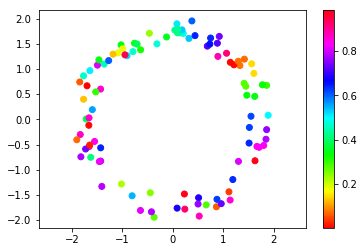

In [22]:
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = mod(result.x[messed_ix], 1.0)
#color = mod(array(l2_cocycle)[messed_ix], 1.0)
scatter(*annulus.T, c=color, cmap="hsv")
plt.colorbar()
plt.axis('equal')

(array([4., 3., 4., 6., 3., 6., 7., 4., 2., 5., 8., 4., 4., 4., 3., 6., 9.,
        6., 5., 7.]),
 array([0.00366133, 0.05233439, 0.10100746, 0.14968053, 0.1983536 ,
        0.24702666, 0.29569973, 0.3443728 , 0.39304587, 0.44171894,
        0.490392  , 0.53906507, 0.58773814, 0.63641121, 0.68508427,
        0.73375734, 0.78243041, 0.83110348, 0.87977655, 0.92844961,
        0.97712268]),
 <a list of 20 Patch objects>)

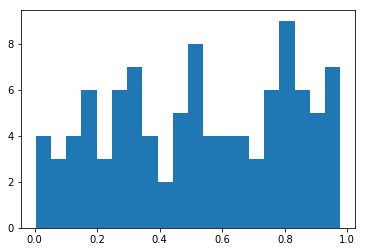

In [81]:
plt.hist(color, bins= 20)